In [49]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import os

cwd = os.getcwd()
print(cwd)


e:\Facultate\practica\seq2seq


In [1]:
from torchtext.legacy import data

ModuleNotFoundError: No module named 'torchtext.legacy'

In [50]:
##########################Load Libraries  ####################################
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
import matplotlib.pyplot as plt



from itertools import cycle
import datetime as dt
import random 
import os
from matplotlib.pyplot import figure

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import Dataset
import torch 



%matplotlib inline

#from gensim.models import Word2Vec
#import gensim.downloader as api


plt.style.use('bmh')
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

 

In [51]:
import torch



device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))
print(torch.__version__)

Using cuda device
2.0.1+cu117


In [52]:
import os

data_dir = "./jena_climate"
fname = os.path.join(data_dir, "jena_climate_2009_2016.csv")
f = open(fname)
data = f.read()
f.close()
lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(header))
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
15
420451


In [53]:
# preprocessing

import pandas as pd
float_data = torch.tensor(
    pd.read_csv(fname).drop("Date Time", axis=1).drop(0, axis=0).astype(float).values,
    dtype=torch.float,
).to(device)
mean = float_data.mean(axis=0)
float_data -= mean
std = float_data.std(axis=0)
float_data /= std

print(mean)
print(std)
print(float_data[:5, :5])

tensor([ 989.2125,    9.4486,  283.4912,    4.9540,   76.0070,   13.5751,
           9.5325,    4.0425,    6.0216,    9.6390, 1216.0697,    2.1303,
           3.5324,  174.7262], device='cuda:0')
tensor([ 8.3595,  8.4237,  8.5048,  6.7304, 16.4771,  7.7395,  4.1839,  4.8973,
         2.6560,  4.2351, 39.9769,  1.5418,  2.3405, 86.6761], device='cuda:0')
tensor([[ 0.8801, -2.1201, -2.1730, -2.1149,  1.0556],
        [ 0.8754, -2.1319, -2.1848, -2.1194,  1.0859],
        [ 0.8730, -2.1082, -2.1601, -2.0837,  1.1041],
        [ 0.8730, -2.1034, -2.1566, -2.0792,  1.0981],
        [ 0.8718, -2.0773, -2.1295, -2.0406,  1.1163]], device='cuda:0')


In [54]:
import numpy as np
import torch

def floating_window_batch_generator(
    data, sample_len, target_len, min_index, max_index, shuffle=False, 
    batch_size=128, step=6
):
    """
    Generate a batch of subsequences of data.

    Args:
        data: (samples, features)
        sample_len: number of samples in the past.
        target_len: number of samples to predict
        min_index: index of first sample
        max_index: index of last sample , -1
        shuffle: (boolean) if False, return batches in chronological order.
        batch_size: (int)
        step: (int) number of timesteps between samples 
    """ 
    if max_index is None:
        max_index = len(data) - target_len - 1
    i = min_index 

    window_size = (sample_len + target_len) * step

    while 1:
        if shuffle:
            rows = np.random.randint(min_index , max_index - (sample_len + target_len)*step, size=batch_size)
        else:
            if i + batch_size >= max_index - (sample_len + target_len)*step:
                i = min_index  # reset to beggining
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = torch.zeros((len(rows), sample_len, data.shape[-1]))
        targets = torch.zeros((len(rows), target_len, data.shape[-1]))
        for j, row in enumerate(rows):
            indices = range(row, row + window_size, step)
            samples[j] = data[indices[:sample_len]]
            targets[j] = data[indices[sample_len:]]

        
        yield samples, targets

In [55]:
sample_len = 120
step = 6
target_len = 24
batch_size = 128


train_generator = floating_window_batch_generator(
    float_data,
    sample_len=sample_len,
    target_len=target_len,
    min_index=0,
    max_index=200000,
    shuffle=True,
    step=step,
    batch_size=batch_size
)

val_generator = floating_window_batch_generator(
    float_data,
    sample_len=sample_len,
    target_len=target_len,
    min_index=200001,
    max_index=300000,
    step=step,
    batch_size=batch_size
)



In [56]:
samples, targets = next(train_generator)




In [57]:
print(samples.shape)
print(targets.shape)

torch.Size([128, 120, 14])
torch.Size([128, 24, 14])


torch.Size([120])


(-2.0, 2.0)

<Figure size 1500x1700 with 0 Axes>

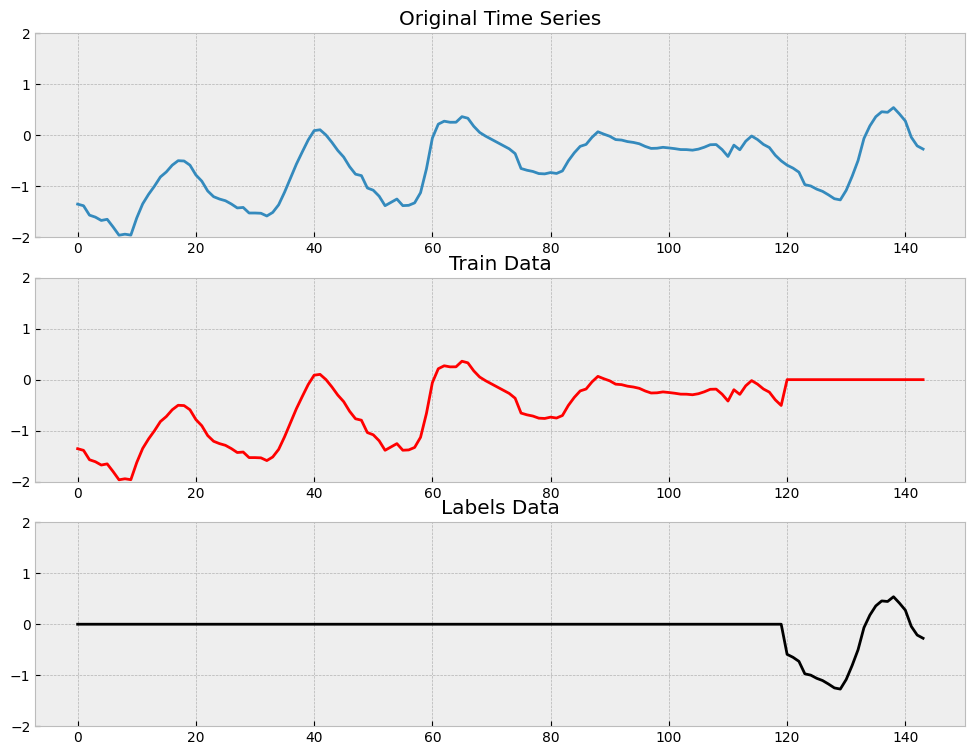

In [58]:
temp_sample = samples[0,:,1]
temp_target = targets[0,:,1]

print(temp_sample.shape)

plt.figure(figsize=(15,17))
fig, axs =plt.subplots(3,figsize=(12,9))

axs[0].plot(torch.cat((temp_sample,temp_target),dim=0).flatten())
axs[0].title.set_text('Original Time Series')
#axs[0].set_xlim(0,seq_length+labels_length)
axs[0].set_ylim(-2,2)
axs[1].plot(torch.cat((temp_sample,torch.zeros(len(temp_target))),dim=0),color="red")
axs[1].title.set_text('Train Data')
#axs[1].set_xlim(0,seq_length+labels_length)
axs[1].set_ylim(-2,2)
axs[2].plot(torch.cat((torch.zeros(len(temp_sample)),temp_target),dim=0),color='black')
axs[2].title.set_text('Labels Data')
#axs[2].set_xlim(0,seq_length+labels_length)
axs[2].set_ylim(-2,2)

In [59]:
class Encoder(nn.Module):
    def __init__(self, seq_len, num_features, hidden_dim=64, num_layers=3):
        super(Encoder, self).__init__()

        self.seq_len = seq_len
        self.num_features = num_features
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.rnn1 = nn.LSTM(
          input_size=num_features,
          hidden_size=self.hidden_dim,
          num_layers=num_layers,
          batch_first=True,
          dropout = 0.35
        )
   
    def forward(self, x):
       
        x = x.reshape((-1, self.seq_len, self.n_features))
              
        x, (hidden, cell) = self.rnn1(x)
        
        

        return x, hidden , cell 

In [60]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        self.attn = nn.Linear((enc_hid_dim ) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
        
    def forward(self, hidden, encoder_outputs):
        

        
        batch_size = encoder_outputs.shape[0]
        src_len = encoder_outputs.shape[1]
        
       
        hidden = hidden[-1,:,:]
        
        #print("hidden size is",hidden.size())
        
        
        
        #repeat decoder hidden state src_len times
        #hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        hidden = hidden.repeat(1, src_len, 1)
     
        
        #encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #print("encode_outputs size after permute is:",encoder_outputs.size())
        
        
        #hidden = [batch size, src len, dec hid dim]
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        
        #energy = [batch size, src len, dec hid dim]

        attention = self.v(energy).squeeze(2)
        
        #attention= [batch size, src len]
        
        
        return F.softmax(attention, dim=1)

In [61]:
class Decoder(nn.Module):
    def __init__(self, seq_len, input_dim=64, num_features=1):
        super(Decoder, self).__init__()

        self.seq_len, self.input_dim = seq_len, input_dim
        self.hidden_dim, self.num_features =  input_dim, num_features
        
        self.rnn1 = nn.LSTM(
          input_size=1,
          hidden_size=input_dim,
          num_layers=3,
          batch_first=True,
          dropout = 0.35
        )
        
        
      
        self.output_layer = nn.Linear(self.hidden_dim, num_features)

    def forward(self, x,input_hidden,input_cell):
       
       
        x = x.reshape((1,1,1))
        
        
     

        x, (hidden_n, cell_n) = self.rnn1(x,(input_hidden,input_cell))
    
        x = self.output_layer(x)
        return x, hidden_n, cell_n

In [62]:
class AttentionDecoder(nn.Module):
    def __init__(self, seq_len,attention, input_dim=64, n_features=1,encoder_hidden_state = 512):
        super(AttentionDecoder, self).__init__()

        self.seq_len, self.input_dim = seq_len, input_dim
        self.hidden_dim, self.n_features =  input_dim, n_features
        self.attention = attention 
        
        self.rnn1 = nn.LSTM(
          #input_size=1,
          input_size= encoder_hidden_state + 1,  # Encoder Hidden State + One Previous input
          hidden_size=input_dim,
          num_layers=3,
          batch_first=True,
          dropout = 0.35
        )
        
        
      
        self.output_layer = nn.Linear(self.hidden_dim * 2 , n_features)

    def forward(self, x,input_hidden,input_cell,encoder_outputs):
       
        a = self.attention(input_hidden, encoder_outputs)
        
        a = a.unsqueeze(1)
        
        #a = [batch size, 1, src len]
        
        #encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
      
        
        weighted = torch.bmm(a, encoder_outputs)
        
        
     
        x = x.reshape((1,1,1))
       
        
        
        rnn_input = torch.cat((x, weighted), dim = 2)
       

        #x, (hidden_n, cell_n) = self.rnn1(x,(input_hidden,input_cell))
        x, (hidden_n, cell_n) = self.rnn1(rnn_input,(input_hidden,input_cell))
        
        output = x.squeeze(0)
        weighted = weighted.squeeze(0)
        
        x = self.output_layer(torch.cat((output, weighted), dim = 1))
        return x, hidden_n, cell_n
    
      

In [63]:
class Seq2Seq(nn.Module):

    def __init__(self, seq_len, n_features, embedding_dim=64,output_length = 28):
        super(Seq2Seq, self).__init__()

        
        self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
        self.attention = Attention(512,512)
        self.output_length = output_length
        self.decoder = AttentionDecoder(seq_len, self.attention, embedding_dim, n_features).to(device)
        

    def forward(self,x, prev_y):
        
        encoder_output,hidden,cell = self.encoder(x)
         
        #Prepare place holder for decoder output
        targets_ta = []
        #prev_output become the next input to the LSTM cell
        prev_output = prev_y
        
        #itearate over LSTM - according to the required output days
        for out_days in range(self.output_length) :
        
            prev_x,prev_hidden,prev_cell = self.decoder(prev_output,hidden,cell,encoder_output)
            hidden,cell = prev_hidden,prev_cell
            prev_output = prev_x
            
            targets_ta.append(prev_x.reshape(1))
           
            
        
        
        targets = torch.stack(targets_ta)

        return targets

In [65]:
n_features = 1
model = Seq2Seq(sample_len, n_features, 512)
model = model.to(device)

In [ ]:
model

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        
model.apply(init_weights)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=4e-3,weight_decay=1e-5)
criterion = torch.nn.MSELoss().to(device) 
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 5e-3, eta_min=1e-8, last_epoch=-1)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  patience=10, factor =0.5 ,min_lr=1e-7, eps=1e-08)

In [ ]:
def train_model(model, TrainX,Trainy,ValidX,Validy,seq_length, n_epochs):
  
    history = dict(train=[], val=[])

    #best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 10000.0
    mb = master_bar(range(1, n_epochs + 1))

    for epoch in mb:
        model = model.train()

        train_losses = []
        for i in progress_bar(range(TrainX.size()[0]),parent=mb):
            seq_inp = TrainX[i,:,:].to(device)
            seq_true = Trainy[i,:,:].to(device)
           
            optimizer.zero_grad()

            
            seq_pred = model(seq_inp,seq_inp[seq_length-1:seq_length,:])
            
            
            loss = criterion(seq_pred, seq_true)

            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
            optimizer.step()

            train_losses.append(loss.item())

        val_losses = []
        model = model.eval()
        with torch.no_grad():
            for i in progress_bar(range(validX.size()[0]),parent=mb):
                seq_inp = ValidX[i,:,:].to(device)
                seq_true = Validy[i,:,:].to(device)
        
                seq_pred = model(seq_inp,seq_inp[seq_length-1:seq_length,:])
               

                loss = criterion(seq_pred, seq_true)
                val_losses.append(loss.item())

        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)

        history['train'].append(train_loss)
        history['val'].append(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pt')
            print("saved best model epoch:",epoch,"val loss is:",val_loss)
        
        print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')
        scheduler.step()
    #model.load_state_dict(best_model_wts)
    return model.eval(), history

In [ ]:
model, history = train_model(
  model,
  trainX,trainy,
  validX,validy,
  seq_length,
  n_epochs=30, ## Training only on 30 epochs to save GPU time 
    
)

In [ ]:
TestX = np.array(TS_selected.iloc[-118:-28:,:])
Testy = np.array(TS_selected.iloc[-28:,:])
TestX = Variable(torch.Tensor(TestX))
 

In [ ]:
TestX_Diff = difference(TestX, interval)
TestX_Diff_Norm = scaler.transform(np.array(TestX_Diff).reshape(len(TestX_Diff),1))

In [ ]:
######Prediction###############
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

with torch.no_grad():
    seq_inp = TestX.to(device)
    
        
    seq_pred = model(seq_inp,seq_inp[seq_length-1:seq_length,:])
          


In [ ]:
data_predict = scaler.inverse_transform(seq_pred.cpu().numpy())
labels = Testy

In [ ]:
orignal_data = np.array(TS_selected.iloc[-118:-28:,:]).flatten()
pred = data_predict.flatten()
orig_pred = np.concatenate([orignal_data,pred])


In [ ]:
time_diff = 7 
inv_pred = np.zeros((28))
for  index in range(28):
    inv_pred[index] = orig_pred[90+index]+ orig_pred[90+index-7]
    orig_pred[90+index] = inv_pred[index]


In [ ]:
data_predict= np.array(inv_pred)
data_predict = np.where(data_predict<0,0,data_predict)


In [ ]:
## Add dates
df_predict = pd.DataFrame(data_predict)
df_predict = df_predict.set_index([dates_list[-28:]])
df_labels = pd.DataFrame(labels)
df_labels = df_labels.set_index([dates_list[-28:]])

# Plot 
figure(num=None, figsize=(24, 6), dpi=80, facecolor='w', edgecolor='k')
#plt.axvline(x=dates_list[train_size], c='r')
plt.plot( df_labels[0])
plt.plot(df_predict[0])
plt.legend(['Time Series','Prediction'],fontsize = 21)
plt.suptitle('Time-Series Prediction Last 28 Days',fontsize = 23)
plt.xticks(fontsize=21 )
plt.yticks(fontsize=21 )
plt.ylabel(ylabel = 'Sales Demand',fontsize = 21)
plt.xlabel(xlabel = 'Date',fontsize = 21)
plt.show()


In [ ]:
np.sqrt(((data_predict - labels) ** 2).mean())